In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Preparing the Dataset
Let us load the fashion mnist dataset from Keras data sets.

We shall then split the data into train, validation, and test parts.

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


Scale the X_train_full and X_test data sets with 255.

In [5]:
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

Slice the X_train_full, such that the last 5000 samples form the validation data X_valid and the remaining samples form the train data X_train.

In [6]:
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]

In [7]:
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

### Defining some Utility Functions
- We shall define 3 utility functions which we will be using further:

  - rounded_accuracy: we define this function to get the rounded accuracy by calculating the accuracies using the rounded values of the predicted value and the actual value.

  - plot_image : used to plot the given image

  - show_reconstructions : we shall use this function to show how our trained model is able to reconstruct the validation data.

**Note:**

- keras.metrics.binary_accuracy : calculates how often predictions matches binary labels. It computes the mean accuracy rate across all predictions for binary classification problems.

- plt.imshow : Display data as an image

- plt.axis("off") : It does not display the axis.

- plt.subplot : Add a subplot to the current figure.

In [8]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [9]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [10]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

Here, we are doing the following:

we are getting the reconstructions as predicted by the model.
we are creating a matplotlib figure object and setting its size to (n_images * 1.5, 3), ie (5 * 1.5, 3)
Nextly, for each of the n_images, we are creating the subplots and displaying the images in those subplots: the first row will display actual images and the second row will display the predicted images. The indices are set accordingly. Please have a look at the below image and check the indices used in the subplots to get a better understanding:

![image](https://cxl-web-prod-uploads.s3.amazonaws.com/public/pagedown-uploads/4ee776017fac7dc9335827175870ad9011c53026.png)

### Building the Autoencoder
Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

Define the encoder stacked_encoder with a flattened input layer, along with 2 dense layers - one with 100 neurons - selu activation while the other with 30 neurons - selu activation function. We shall add these layers to keras.models.Sequential.

In [11]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])

Similarly, we shall define the encoder stacked_decoder with 2 dense layers - one with 100 neurons - selu activation while the other with 28*28 neurons - sigmoid activation function, followed by an output layer of shape 28 x 28. We shall add these layers to keras.models.Sequential.

In [12]:
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

We shall now club the stacked_encoder and stacked_decoder using keras.models.Sequential to form our complete autoencoder stacked_ae.

In [13]:
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

In [16]:
stacked_ae.compile(loss="binary_crossentropy",
           optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])

### Training the Autoencoder
Let us fit the autoencoder model to the train data.

In [17]:
import time
start = time.time()

In [18]:
history = stacked_ae.fit(X_train, X_train, epochs=20,
                 validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 7s 3ms/step - loss: 0.3815 - rounded_accuracy: 0.8487 - val_loss: 0.3164 - val_rounded_accuracy: 0.9006
Epoch 2/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3083 - rounded_accuracy: 0.9127 - val_loss: 0.3021 - val_rounded_accuracy: 0.9199
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2998 - rounded_accuracy: 0.9203 - val_loss: 0.2987 - val_rounded_accuracy: 0.9195
Epoch 4/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2959 - rounded_accuracy: 0.9240 - val_loss: 0.2938 - val_rounded_accuracy: 0.9286
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2928 - rounded_accuracy: 0.9268 - val_loss: 0.2919 - val_rounded_accuracy: 0.9285
Epoch 6/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2920 - rounded_accuracy: 0.9283 - val_loss: 0.2915 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [==================

In [19]:
end = time.time()

In [20]:
print("Time of execution:", round(end-start,2),"seconds")

Time of execution: 104.85 seconds


### Evaluating the Model Performance
Let us now view how well our autoencoder is trained and how good the reconstructed images are trained.

Use show_reconstructions function and pass stacked_ae and X_test as input argument. This displays 5 ground truth images and the corresponding reconstructed images.

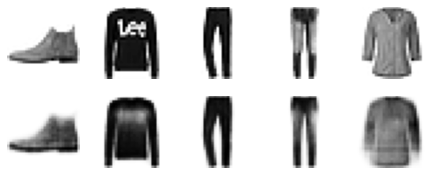

In [21]:
show_reconstructions(stacked_ae, X_test)

In [23]:
stacked_ae.evaluate(X_test, X_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2845 - rounded_accuracy: 0.9365


[0.2845265567302704, 0.9364709854125977]

Let us view the class-wise clusters for the validation data as predicted by our model stacked_ae. Since we can't display multiple-dimensions, we shall do this by using TSNE dimensionality reduction.

We shall use predict of stacked_encoder on X_valid to get the compressed data of the validation data.

Use fit_transform of TSNE() to get the 2D representation of the compressed validation data and scale it data.

Now plot this data with colormaps for each class.

Use the following code to do get the 2D representation of the compressed validation data.

In [24]:
np.random.seed(42)

from sklearn.manifold import TSNE

start = time.time()

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

end = time.time()

print("Time of execution:", round(end-start,2),"seconds")

Time of execution: 31.05 seconds


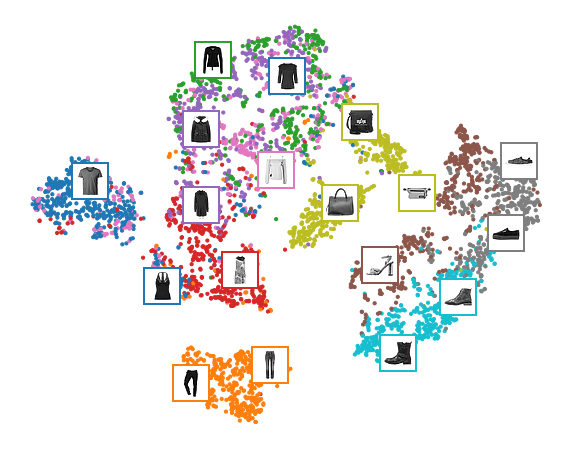

In [25]:
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()